<a href="https://colab.research.google.com/github/sruthireddy1482/CE888/blob/main/Assignment2/London_police_bias_mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [ ]:
from aif360.algorithms.preprocessing import Reweighing

In [ ]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [ ]:
dataframe=pd.read_csv("https://raw.githubusercontent.com/sruthireddy1482/CE888/main/London-stopandserach.csv")
dataframe.head()

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,2020-07-01T02:16:55+00:00,NaN,NaN,51.517196,-0.085149,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
1,Person search,2020-07-01T02:16:55+00:00,NaN,NaN,51.517196,-0.085149,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person and Vehicle search,2020-07-01T03:10:05+00:00,NaN,NaN,51.512117,-0.102411,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False
3,Person and Vehicle search,2020-07-01T03:10:05+00:00,NaN,NaN,51.512117,-0.102411,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False
4,Person search,2020-07-01T03:16:33+00:00,NaN,NaN,51.512117,-0.102411,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False


In [ ]:
null = ['Part of a policing operation','Policing operation']
df = dataframe.drop(columns=null,axis=1)
df.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,2020-07-01T02:16:55+00:00,51.517196,-0.085149,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
1,Person search,2020-07-01T02:16:55+00:00,51.517196,-0.085149,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person and Vehicle search,2020-07-01T03:10:05+00:00,51.512117,-0.102411,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False
3,Person and Vehicle search,2020-07-01T03:10:05+00:00,51.512117,-0.102411,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False
4,Person search,2020-07-01T03:16:33+00:00,51.512117,-0.102411,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False


In [ ]:
df_updated = df.drop(columns=['Date','Latitude','Longitude'])
df_updated.head(3)

,Type,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
1,Person search,Male,18-24,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
2,Person and Vehicle search,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False


In [ ]:
from sklearn import preprocessing 
label = preprocessing.LabelEncoder() 
cols=['Removal of more than just outer clothing','Self-defined ethnicity']
df[cols] = df[cols].astype(str)
df1_lc = df[cols].apply(preprocessing.LabelEncoder().fit_transform)

In [ ]:
df1_lc

,Removal of more than just outer clothing,Self-defined ethnicity
0,0,13
1,0,13
2,0,15
3,0,15
4,0,15
...,...,...
1856,0,13
1857,0,14
1858,0,13
1859,0,14


In [ ]:
df_onehot = pd.concat([df1_lc, pd.get_dummies(df[['Gender', 'Outcome']])], axis=1)

In [ ]:
df_onehot.head(3)

,Removal of more than just outer clothing,Self-defined ethnicity,Gender_Female,Gender_Male,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post
0,0,13,0,1,1,0,0,0,0,0,0
1,0,13,0,1,1,0,0,0,0,0,0
2,0,15,1,0,0,1,0,0,0,0,0


In [ ]:
df_final=df_onehot.dropna(axis=0)
df_final.head()

,Removal of more than just outer clothing,Self-defined ethnicity,Gender_Female,Gender_Male,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post
0,0,13,0,1,1,0,0,0,0,0,0
1,0,13,0,1,1,0,0,0,0,0,0
2,0,15,1,0,0,1,0,0,0,0,0
3,0,15,1,0,0,1,0,0,0,0,0
4,0,15,0,1,0,1,0,0,0,0,0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 0 to 1860
Data columns (total 11 columns):
Removal of more than just outer clothing    1861 non-null int32
Self-defined ethnicity                      1861 non-null int32
Gender_Female                               1861 non-null uint8
Gender_Male                                 1861 non-null uint8
Outcome_A no further action disposal        1861 non-null uint8
Outcome_Arrest                              1861 non-null uint8
Outcome_Caution (simple or conditional)     1861 non-null uint8
Outcome_Community resolution                1861 non-null uint8
Outcome_Khat or Cannabis warning            1861 non-null uint8
Outcome_Penalty Notice for Disorder         1861 non-null uint8
Outcome_Summons / charged by post           1861 non-null uint8
dtypes: int32(2), uint8(9)
memory usage: 45.4 KB


In [ ]:
df_aif = BinaryLabelDataset(df= df_final.drop('Gender_Female', axis=1), label_names=['Gender_Male'], protected_attribute_names=['Removal of more than just outer clothing'])

In [ ]:
df_aif

               instance weights                                 features  \
                                                     protected attribute   
                                Removal of more than just outer clothing   
instance names                                                             
0                           1.0                                      0.0   
1                           1.0                                      0.0   
2                           1.0                                      0.0   
3                           1.0                                      0.0   
4                           1.0                                      0.0   
...                         ...                                      ...   
1856                        1.0                                      0.0   
1857                        1.0                                      0.0   
1858                        1.0                                      0.0   
1859        

In [ ]:
privileged_group = [{'Removal of more than just outer clothing': 0}]
unprivileged_group = [{'Removal of more than just outer clothing': 1}]

In [ ]:
privileged_group

[{'Removal of more than just outer clothing': 0}]

In [ ]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(930, 9), (558, 9), (373, 9)]


In [ ]:
df_orig_trn

               instance weights                                 features  \
                                                     protected attribute   
                                Removal of more than just outer clothing   
instance names                                                             
400                         1.0                                      0.0   
664                         1.0                                      0.0   
351                         1.0                                      0.0   
1065                        1.0                                      0.0   
1368                        1.0                                      0.0   
...                         ...                                      ...   
785                         1.0                                      0.0   
1593                        1.0                                      0.0   
1446                        1.0                                      0.0   
345         

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.037


In [ ]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 100)


In [ ]:
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)


In [ ]:
from aif360.metrics import ClassificationMetric
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1230.13it/s]


In [ ]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.01
Best balanced accuracy: 0.5
1-min(DI, 1/DI): 0.0


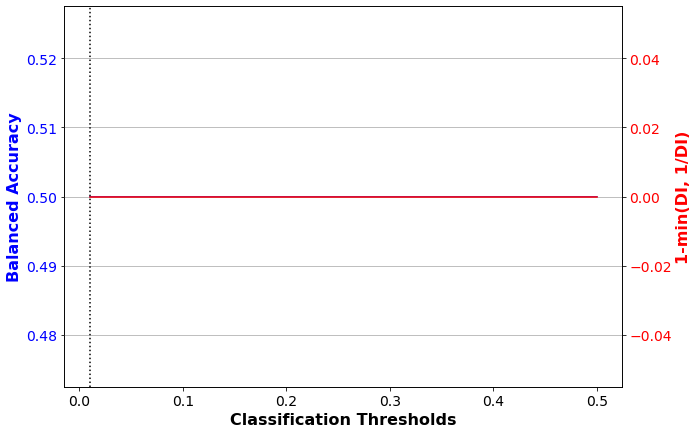

In [ ]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

In [ ]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

In [ ]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


In [ ]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)


In [ ]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)


In [ ]:
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1091.32it/s]


In [ ]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.01
Best balanced accuracy: 0.5
1-min(DI, 1/DI): 0.0


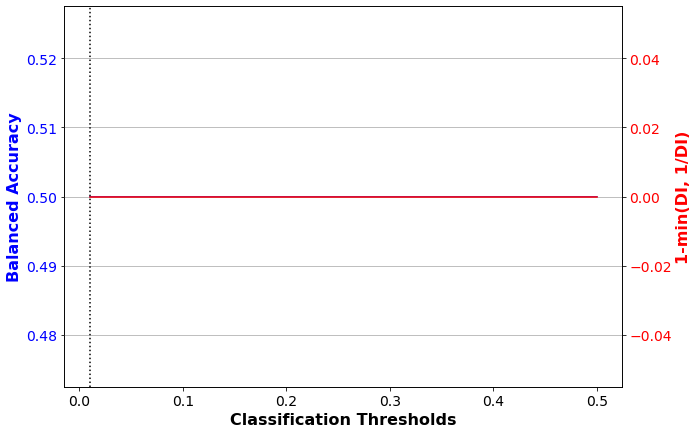

In [ ]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))